## 0 Imports

In [259]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor, XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats
import warnings
from matplotlib.ticker import FuncFormatter

### 0.1 Helper Functions

In [260]:
pd.set_option('display.float_format', '{:.2f}'.format)

warnings.filterwarnings("ignore")

def cross_validation_ordered_model(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': [],
        'mae': [],
        'pseudo_r2': []
    }
    
    fold_counter = 1  # Contador de folds para plotagem
    
    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        print(f'Processing fold {fold}/{n_splits}... (vai demorá uma cota hehe)')
        
        # Dividir os dados em conjuntos de treino e teste
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Manter y como DataFrame

        # Ajustar o modelo
        ordinal_logistic_model = OrderedModel(y_train.values.ravel(), X_train, distr='logit')  # y_train como array
        result = ordinal_logistic_model.fit(method='bfgs')
        
        # Fazer previsões
        y_pred_prob = result.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)  # Obter as classes com base nas probabilidades
        
        # Calcular métricas
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
        metrics['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        metrics['f1_score'].append(f1_score(y_test, y_pred, average='macro', zero_division=0))
        metrics['mae'].append(mean_absolute_error(y_test, y_pred))
        pseudo_r2 = result.prsquared
        metrics['pseudo_r2'].append(pseudo_r2)
        
    # Calcular a média e o desvio padrão das métricas
    results = {metric: (np.mean(values), np.std(values)) for metric, values in metrics.items()}
    
    return results



def format_thousands(x, pos):
    return f'{int(x):,}'.replace(',', '.')

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mse = mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, yhat)
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MSE': mse,
                         'RMSE': rmse,
                         'R²': r2
                         }, 
                        index=[0])

def chi2(modelo_multi):
    maximo = modelo_multi.llf
    minimo = modelo_multi.llnull
    qui2 = -2*(minimo - maximo)
    pvalue = stats.distributions.chi2.sf(qui2, 216)
    df = pd.DataFrame({'Qui_quadrado':[qui2],
      'p_value':[pvalue]})
    return df

def cross_validation(X, y, model, kfold=5):
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
    
    mae_list = []
    mse_list = []
    rmse_list = []
    r2_list = []
    
    #separando a base de validação em 1/n partes e treino em n-1/n partes 
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões
        y_pred = model.predict(X_val)
        
        # Calculando as métricas usando sklearn
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)  
        r2 = r2_score(y_val, y_pred)
        
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        r2_list.append(r2)

    #efetua-se a média de cada erro entre os n modelos
    return pd.DataFrame({
        'MAE': [np.mean(mae_list), np.std(mae_list)],
        'MSE': [np.mean(mse_list), np.std(mse_list)],
        'RMSE': [np.mean(rmse_list), np.std(rmse_list)],
        'R²': [np.mean(r2_list), np.std(r2_list)]
    }, index=['Mean', 'Std'])


def cross_validation_list(X, y, model, kfold=5):
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
    
    mae_list = []
    mse_list = []
    rmse_list = []
    
    # Separando a base de validação em 1/n partes e treino em n-1/n partes 
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões
        y_pred = model.predict(X_val)
        
        # Calculando as métricas usando sklearn
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)  
        
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
    
    # Retornando as listas de erros
    return {
        'MAE': mae_list,
        'MSE': mse_list,
        'RMSE': rmse_list
    }

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data


### 0.2 - Load Data

In [261]:
data_raw = pd.read_csv('C:/Users/Alexandre/Documents/TCC - Data Science e Analytics/beer_reviews.csv')

In [262]:
data = data_raw.copy()

In [263]:
# data = data[['review_overall', 'review_taste', 'review_appearance', 'review_aroma', 'review_palate', 'review_time' ]]

data['review_time'] = pd.to_datetime(data['review_time'], unit='s')  # Se o tempo estiver em formato de segundos Unix

#Filtrando os dados a partir de 01/01/2002
start_date = '2002-01-01'
data = data.loc[data['review_time'] >= start_date]

## 1 Data Description

### 1.1 Data Preview

In [264]:
data.head(5)

,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,0,10325,Vecchio Birraio,2009-02-16 20:57:03,1.50,2.00,2.50,stcules,Hefeweizen,1.50,1.50,Sausa Weizen,5.00,47986
1,1,10325,Vecchio Birraio,2009-03-01 13:44:57,3.00,2.50,3.00,stcules,English Strong Ale,3.00,3.00,Red Moon,6.20,48213
2,2,10325,Vecchio Birraio,2009-03-01 14:10:04,3.00,2.50,3.00,stcules,Foreign / Export Stout,3.00,3.00,Black Horse Black Beer,6.50,48215
3,3,10325,Vecchio Birraio,2009-02-15 19:12:25,3.00,3.00,3.50,stcules,German Pilsener,2.50,3.00,Sausa Pils,5.00,47969
4,4,1075,Caldera Brewing Company,2010-12-30 18:53:26,4.00,4.50,4.00,johnmichaelsen,American Double / Imperial IPA,4.00,4.50,Cauldron DIPA,7.70,64883


### 1.2 Data Dimension

In [265]:
print('Number of rows: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))

Number of rows: 1584276
Number of columns: 14


### 1.3 Rename Columns

### 1.3 Data Types

In [266]:
data.dtypes

index                          int64
brewery_id                     int64
brewery_name                  object
review_time           datetime64[ns]
review_overall               float64
review_aroma                 float64
review_appearance            float64
review_profilename            object
beer_style                    object
review_palate                float64
review_taste                 float64
beer_name                     object
beer_abv                     float64
beer_beerid                    int64
dtype: object

### 1.4 Change dtypes


In [267]:
data['review_time'] = pd.to_datetime(data['review_time'], unit='s')

In [268]:
data['review_overall'] = ((data['review_overall']*2) - 2).astype('int')
data['review_taste'] = ((data['review_taste']*2) - 2).astype('int')
data['review_palate'] = ((data['review_palate']*2) - 2).astype('int')
data['review_aroma'] = ((data['review_aroma']*2) - 2).astype('int')
data['review_appearance'] = ((data['review_appearance']*2) - 2).astype('int')

### 1.5 Check NA's


In [269]:
data.isna().sum()

index                     0
brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67424
beer_beerid               0
dtype: int64

### 1.5 Quality Check

In [270]:
num_attributes = data.select_dtypes(include=['int','float64'])

#medidas de Tendência Central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão

dm1 = pd.DataFrame(num_attributes.apply(np.min)).T
dm2 = pd.DataFrame(num_attributes.apply(np.max)).T
dm3 = pd.DataFrame(num_attributes.apply(np.std)).T
dm4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dm5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dm6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenando para melhorar a visualização
numerical_metrics = pd.concat([dm1,dm2,dm4,ct1,ct2,dm3,dm5,dm6]).T.reset_index()

#renomeando as colunas
numerical_metrics.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

#exibindo o resultado
numerical_metrics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,index,0.00,1586613.00,1586613.00,793207.03,793171.50,458010.21,0.00,-1.20
1,brewery_id,1.00,28003.00,28002.00,3133.20,429.00,5580.34,2.08,3.40
2,review_overall,-2.00,8.00,10.00,5.63,6.00,1.44,-1.02,1.63
3,review_aroma,0.00,8.00,8.00,5.47,6.00,1.39,-0.84,1.14
4,review_appearance,-2.00,8.00,10.00,5.68,6.00,1.23,-0.90,1.74
5,review_palate,0.00,8.00,8.00,5.49,6.00,1.36,-0.87,1.30
6,review_taste,0.00,8.00,8.00,5.59,6.00,1.46,-0.97,1.34
7,beer_abv,0.01,57.70,57.69,7.04,NaN,2.32,1.54,6.96
8,beer_beerid,3.00,77317.00,77314.00,21742.16,14033.00,21819.84,0.69,-0.84


In [271]:
feature_counts = {
    'review_overall': data['review_overall'].value_counts().sort_index(),
    'review_appearance': data['review_appearance'].value_counts().sort_index(),
    'review_taste': data['review_taste'].value_counts().sort_index(),
    'review_palate': data['review_palate'].value_counts().sort_index(),
    'review_aroma': data['review_aroma'].value_counts().sort_index()
}

quality_check = pd.DataFrame(feature_counts)

# Substituir valores NaN por 0 (caso alguma combinação de nota não tenha sido avaliada em uma feature)
quality_check = quality_check.fillna(0)

# Exibindo o dataframe final
quality_check.T

,-2,0,1,2,3,4,5,6,7,8
review_overall,7.00,10893.00,12972.00,38111.00,58513.00,165292.00,301725.00,581749.00,324222.00,90792.00
review_appearance,7.00,3279.00,6146.00,25316.00,39477.00,165528.00,318391.00,673144.00,288009.00,64979.00
review_taste,0.00,9911.00,15127.00,41837.00,66513.00,166498.00,324428.00,540602.00,335964.00,83396.00
review_palate,0.00,6808.00,11044.00,38179.00,62828.00,206423.00,338465.00,605739.00,252981.00,61809.00
review_aroma,0.00,6807.00,12521.00,42402.00,66349.00,199477.00,365166.00,556423.00,271348.00,63783.00


### 1.6 Fillout Inconsistent data

In [272]:
#para as sete observações iguais a 0 em review_overall e review_appearance atribuir a nota mínima
data.loc[(data['review_overall'] == -2) & (data['review_appearance'] == -2), ['review_overall', 'review_appearance']] = 0

### 1.7 Descriptive Statistical


In [273]:
num_attributes = data.select_dtypes(include=['int','float64'])
cat_attributes = data.select_dtypes(exclude=['int','float64','datetime64[ns]'])

#### 1.7.1 Sensorial Variables Num Attributes

In [274]:
#medidas de Tendência Central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão

dm1 = pd.DataFrame(num_attributes.apply(np.min)).T
dm2 = pd.DataFrame(num_attributes.apply(np.max)).T
dm3 = pd.DataFrame(num_attributes.apply(np.std)).T
dm4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dm5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dm6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenando para melhorar a visualização
numerical_metrics = pd.concat([dm1,dm2,dm4,ct1,ct2,dm3,dm5,dm6]).T.reset_index()

#renomeando as colunas
numerical_metrics.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

#exibindo o resultado
numerical_metrics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,index,0.00,1586613.00,1586613.00,793207.03,793171.50,458010.21,0.00,-1.20
1,brewery_id,1.00,28003.00,28002.00,3133.20,429.00,5580.34,2.08,3.40
2,review_overall,0.00,8.00,8.00,5.63,6.00,1.44,-1.02,1.63
3,review_aroma,0.00,8.00,8.00,5.47,6.00,1.39,-0.84,1.14
4,review_appearance,0.00,8.00,8.00,5.68,6.00,1.23,-0.90,1.73
5,review_palate,0.00,8.00,8.00,5.49,6.00,1.36,-0.87,1.30
6,review_taste,0.00,8.00,8.00,5.59,6.00,1.46,-0.97,1.34
7,beer_abv,0.01,57.70,57.69,7.04,NaN,2.32,1.54,6.96
8,beer_beerid,3.00,77317.00,77314.00,21742.16,14033.00,21819.84,0.69,-0.84


#### 1.7.2 Sensorial Cat Num Attributes

In [275]:
feature_counts = {
    'review_overall': data['review_overall'].value_counts().sort_index(),
    'review_appearance': data['review_appearance'].value_counts().sort_index(),
    'review_taste': data['review_taste'].value_counts().sort_index(),
    'review_palate': data['review_palate'].value_counts().sort_index(),
    'review_aroma': data['review_aroma'].value_counts().sort_index()
}

quality_check = pd.DataFrame(feature_counts)

# Substituir valores NaN por 0 (caso alguma combinação de nota não tenha sido avaliada em uma feature)
quality_check = quality_check.fillna(0)

# Exibindo o dataframe final
quality_check.T

,0,1,2,3,4,5,6,7,8
review_overall,10900,12972,38111,58513,165292,301725,581749,324222,90792
review_appearance,3286,6146,25316,39477,165528,318391,673144,288009,64979
review_taste,9911,15127,41837,66513,166498,324428,540602,335964,83396
review_palate,6808,11044,38179,62828,206423,338465,605739,252981,61809
review_aroma,6807,12521,42402,66349,199477,365166,556423,271348,63783


## 2 Feature Engineering

In [276]:
#year_month_day
data['year_month_day'] = data['review_time'].dt.strftime('%Y-%m-%d')

#year
data['year'] = data['review_time'].dt.year

#month
data['month'] = data['review_time'].dt.month

#day
data['day'] = data['review_time'].dt.day

#year week
data['year_week'] = data['review_time'].dt.strftime('%Y-%U')

#year month
data['year_month'] = data['review_time'].dt.strftime('%Y-%m')

#year semester
data['year_semester'] = data['review_time'].dt.year.astype(str) + '-S' + ((data['review_time'].dt.month - 1) // 6 + 1).astype(str)

#year quarter
data['year_quarter'] = data['review_time'].dt.year.astype(str) + '-Q' + ((data['review_time'].dt.month - 1) // 3 + 1).astype(str)

## 3 Exploratory Data Analysis

### 3.1 Univariated Analysis

#### 3.1.1 Response Variable

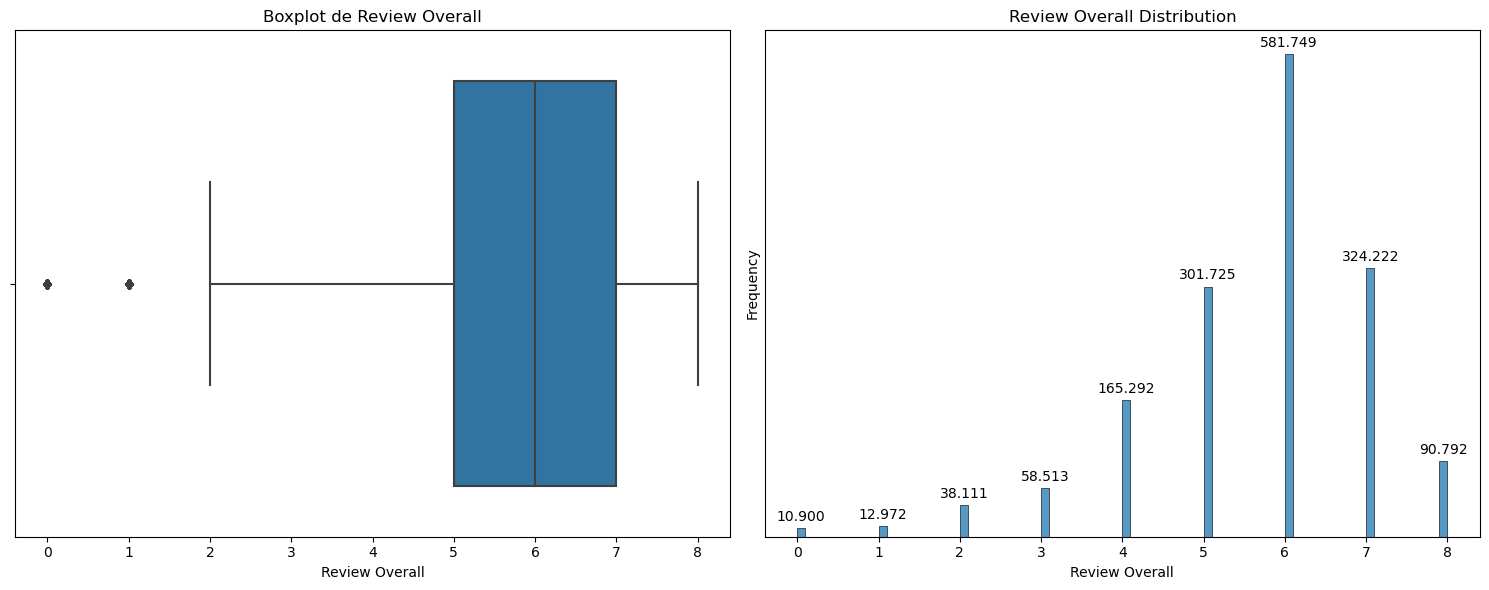

In [277]:
# Criar subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1 - Boxplot de 'review_overall'
sns.boxplot(data=data, x='review_overall', ax=axes[0])
axes[0].set_title('Boxplot de Review Overall')
axes[0].set_xlabel('Review Overall')

# Gráfico 2 - Histograma de 'review_overall'
histplot = sns.histplot(data=data, x='review_overall', binwidth=0.1, ax=axes[1])

# Adicionando rótulos de frequência ao histograma com separador de milhar (ponto)
for patch in histplot.patches:
    height = patch.get_height()
    if height > 0:
        histplot.annotate(f'{int(height):,}'.replace(",", "."), 
                          xy=(patch.get_x() + patch.get_width() / 2, height), 
                          xytext=(0, 3), 
                          textcoords="offset points", 
                          ha='center', va='bottom')

# Configurações do eixo Y e títulos
axes[1].yaxis.set_ticks([])  # Remover ticks do eixo Y no histograma
axes[1].set_title('Review Overall Distribution')
axes[1].set_xlabel('Review Overall')
axes[1].set_ylabel('Frequency')

# Ajustar espaçamento entre os gráficos
plt.tight_layout()

# Exibir o gráfico
plt.show()

#### 3.1.2 Sensorial Variables

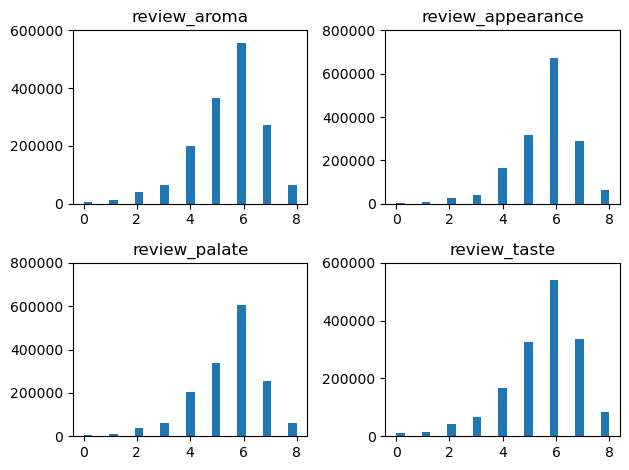

In [278]:
import matplotlib.pyplot as plt

# Agrupar os dados
grouped_view = data[['review_aroma', 'review_appearance', 'review_palate', 'review_taste']]

# Criar histogramas
axes = grouped_view.hist(bins=25)

# Remover rótulos de dados e linhas de grade
for ax in axes.flatten():
    # Ocultar as linhas de grade
    ax.grid(False)
    
    # Manter os valores no eixo y
    ax.set_yticks(ax.get_yticks())  # Isso garante que os rótulos do eixo y sejam mantidos

# Exibir o gráfico
plt.tight_layout()
plt.show()


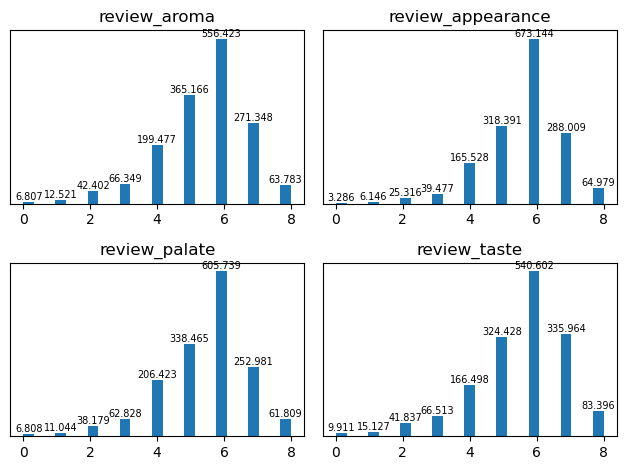

In [279]:
# Agrupar os dados
grouped_view = data[['review_aroma', 'review_appearance', 'review_palate', 'review_taste']]

# Criar histogramas
axes = grouped_view.hist(bins=25)

# Adicionar rótulos de dados, evitando zeros
for ax in axes.flatten():
    for p in ax.patches:  # Iterar sobre cada barra do histograma
        height = int(p.get_height())
        ax.grid(False)
        if height > 0:  # Verificar se a altura é maior que zero
            ax.annotate(f'{height:,}'.replace(',', '.'),  # Rótulo com a altura da barra e ponto como separador
                         (p.get_x() + p.get_width() / 2, height),  # Posição do rótulo
                         ha='center', va='bottom', fontsize=7)  # Ajustar o tamanho da fonte
    ax.set_yticks([])  # Ocultar o eixo y

# Exibir o gráfico
plt.tight_layout()
plt.show()

### 3.2 Bivariated Analysis

In [280]:
initial_date =  data['review_time'].min() 
final_date = data['review_time'].max()
delta_time = relativedelta(final_date, initial_date)

print(f"Initial Date: {initial_date}")
print(f"Final Date: {final_date}")
print(f"Time Interval: {delta_time.years} years and {delta_time.years} months")

Initial Date: 2002-01-01 06:50:03
Final Date: 2012-01-11 12:35:48
Time Interval: 10 years and 10 months


#### 3.2.1 Response Variable

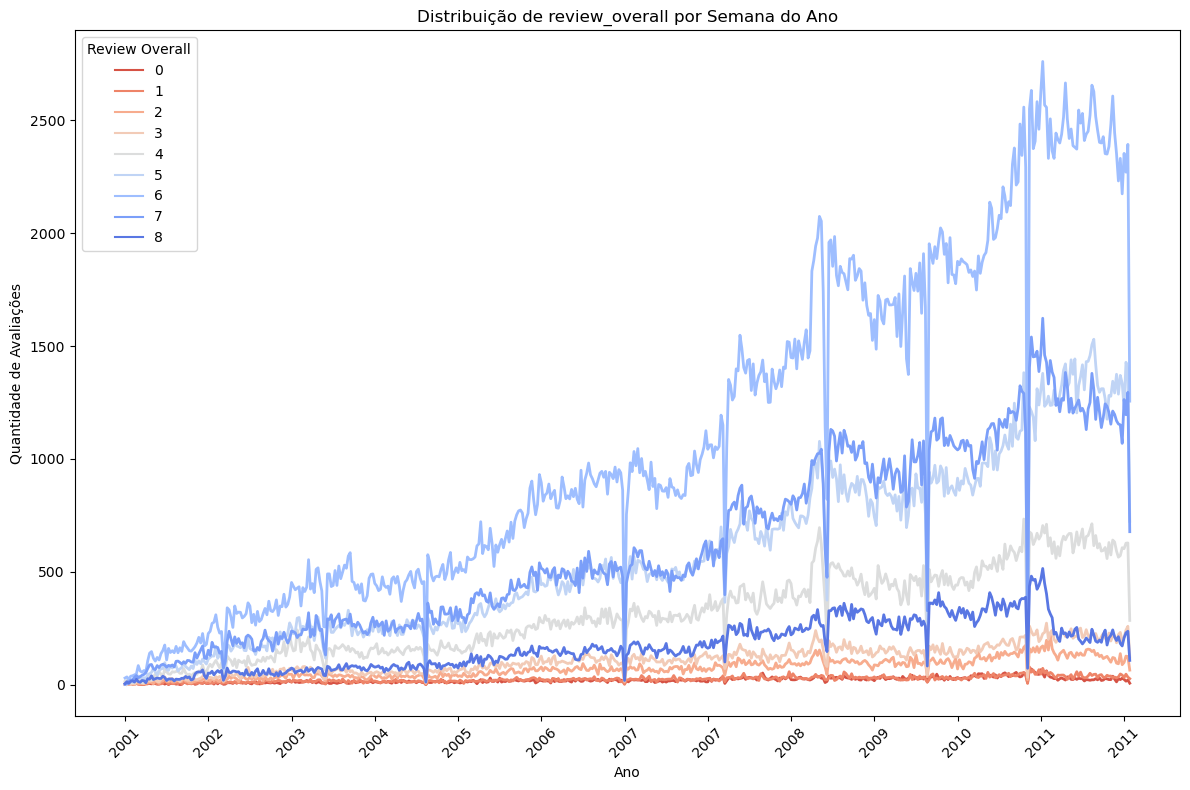

In [281]:
# Agrupando os dados por 'year_week' e 'review_taste'
freq_data = data.groupby(['year_week', 'review_overall']).size().reset_index(name='count')

# Convertendo 'year_week' para uma data completa
freq_data['date'] = pd.to_datetime(freq_data['year_week'] + '-1', format='%Y-%W-%w')  

# Extraindo o ano
freq_data['year'] = freq_data['date'].dt.year

# Criar o gráfico de linha
palette = sns.color_palette("coolwarm_r", n_colors=9)
plt.figure(figsize=(12, 8))

# Gráfico de linha com 'hue' para 'review_taste'
sns.lineplot(data=freq_data, x='year_week', y='count', hue='review_overall', palette=palette, linewidth=2)

# Ajustar o rótulo dos eixos e título
plt.xlabel('Ano')
plt.ylabel('Quantidade de Avaliações')
plt.title('Distribuição de review_overall por Semana do Ano')

# Gerar rótulos anuais no eixo X
unique_weeks = freq_data['year_week'].unique()
unique_quarters = freq_data.groupby('year_week')['year'].first()

# Ajustar os ticks do eixo X para todos os trimestres
plt.xticks(ticks=unique_weeks[::len(unique_weeks)//12], labels=unique_quarters[::len(unique_weeks)//12].astype(str), rotation=45, fontsize=10)

# Remover linhas de grade
plt.grid(False)

# Legenda
plt.legend(title='Review Overall', loc='upper left')

plt.tight_layout()
plt.show()

#### 3.2.2 Sensorial Variables

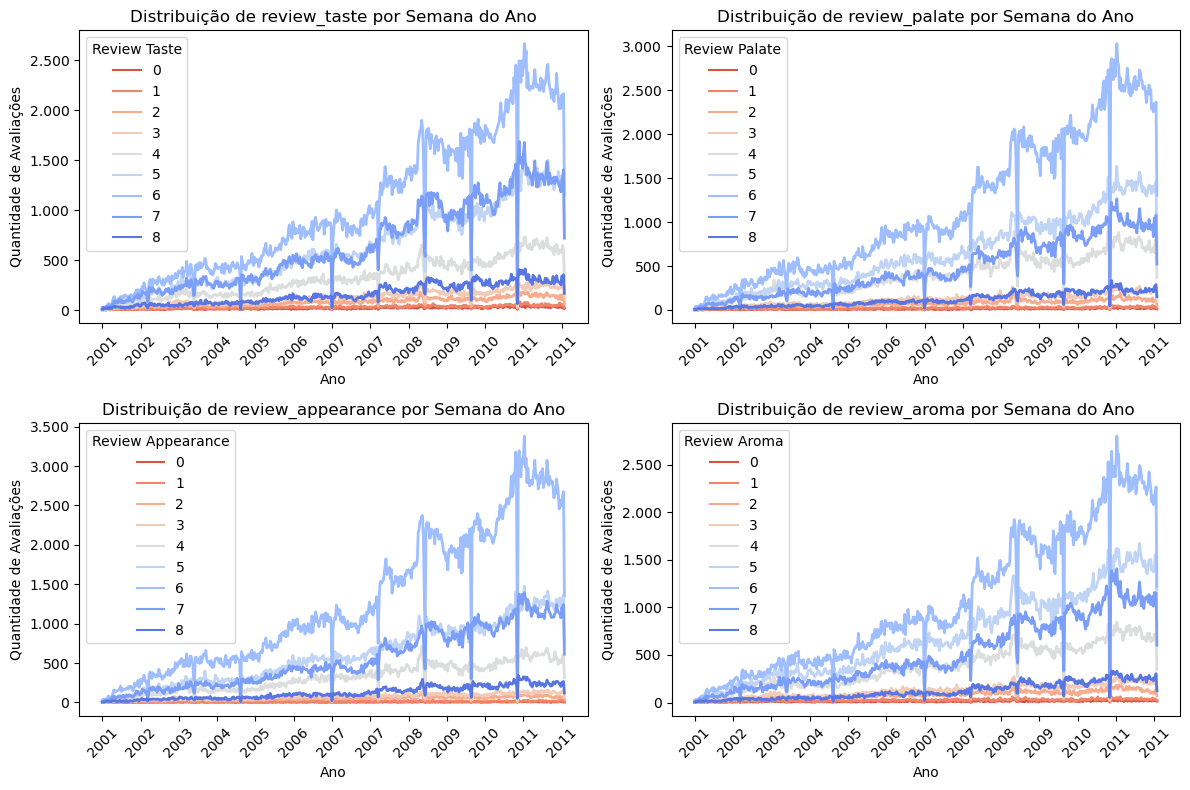

In [282]:
# Função para formatar os números com ponto como separador de milhar


# Criar uma figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Transformar a matriz de eixos em um array unidimensional

# Lista dos títulos e variáveis de review
titles = ['Distribuição de review_taste por Semana do Ano', 
          'Distribuição de review_palate por Semana do Ano', 
          'Distribuição de review_appearance por Semana do Ano', 
          'Distribuição de review_aroma por Semana do Ano']
reviews = ['review_taste', 'review_palate', 'review_appearance', 'review_aroma']

for i, review in enumerate(reviews):
    # Agrupando os dados por 'year_week' e a variável de review
    freq_data = data.groupby(['year_week', review]).size().reset_index(name='count')
    
    # Convertendo 'year_week' para uma data completa
    freq_data['date'] = pd.to_datetime(freq_data['year_week'] + '-1', format='%Y-%W-%w')  
    freq_data['year'] = freq_data['date'].dt.year  # Extraindo o ano

    # Gráfico de linha com 'hue' para a variável de review
    palette = sns.color_palette("coolwarm_r", n_colors=9)
    sns.lineplot(data=freq_data, x='year_week', y='count', hue=review, palette=palette, linewidth=2, ax=axes[i])

    # Ajustar o rótulo dos eixos e título
    axes[i].set_xlabel('Ano')
    axes[i].set_ylabel('Quantidade de Avaliações')
    axes[i].set_title(titles[i])

    # Gerar rótulos anuais no eixo X
    unique_weeks = freq_data['year_week'].unique()
    unique_quarters = freq_data.groupby('year_week')['year'].first()
    
    # Ajustar os ticks do eixo X
    axes[i].set_xticks(ticks=unique_weeks[::len(unique_weeks)//12])
    axes[i].set_xticklabels(unique_quarters[::len(unique_weeks)//12].astype(str), rotation=45, fontsize=10)

    # Remover linhas de grade
    axes[i].grid(False)

    # Formatar os valores do eixo Y com ponto como separador de milhar
    axes[i].yaxis.set_major_formatter(FuncFormatter(format_thousands))

    # Legenda
    axes[i].legend(title=review.replace('_', ' ').title(), loc='upper left')

# Ajustar layout
plt.tight_layout()
plt.show()

### 3.3 Multivariated Analysis

<Axes: >

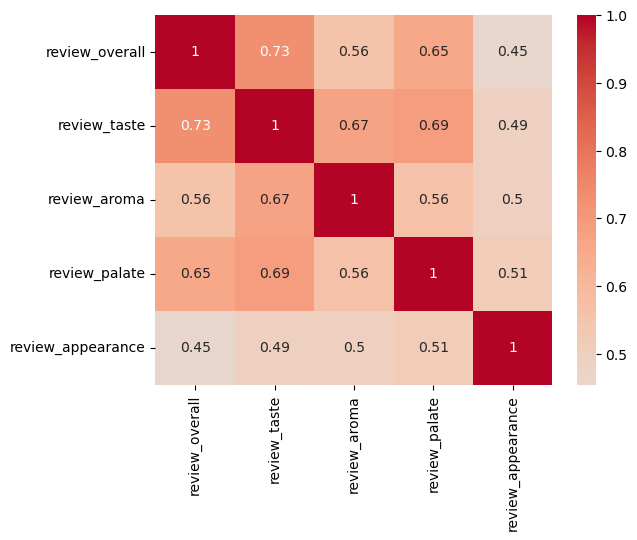

In [283]:
corr = data[['review_overall','review_taste', 'review_aroma','review_palate','review_appearance']]

corr_matrix, p_values = spearmanr(corr)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0.4,
            xticklabels=corr.columns, yticklabels=corr.columns)

In [284]:
print(f"Valor p: {p_values}")

Valor p: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


## 4 Data Preparation

### 4.1 Variables Selection

In [285]:
#selecionando as variáveis
X = data[['review_taste', 'review_aroma','review_palate','review_appearance']]

In [286]:
X_raw = X.copy()

### 4.2 Encoding

In [287]:
#transformando em category para que a função .get_dummies funcione
X = X.astype('category')

### 4.2 Get Dummies

###### Nota: drop_first=True remove a categoria de referência para evitar a multicolinearidade perfeita

In [288]:
X_dummies = pd.get_dummies(X, drop_first=True).astype('int')

### 4.3 Response Variable

In [369]:
y_raw = data[['review_overall']]

In [370]:
y = y_raw.astype('category')

### 4.4 Checking Sizes

In [291]:
print(f"y Shape: {y.shape}")
print(f"X Shape: {X_dummies.shape}")

y Shape: (1584276, 1)
X Shape: (1584276, 32)


### 4.5 Multicolinearity check

In [292]:
df= pd.concat([y, X_dummies], axis=1)

#### 4.5.1 Spearman Correlation

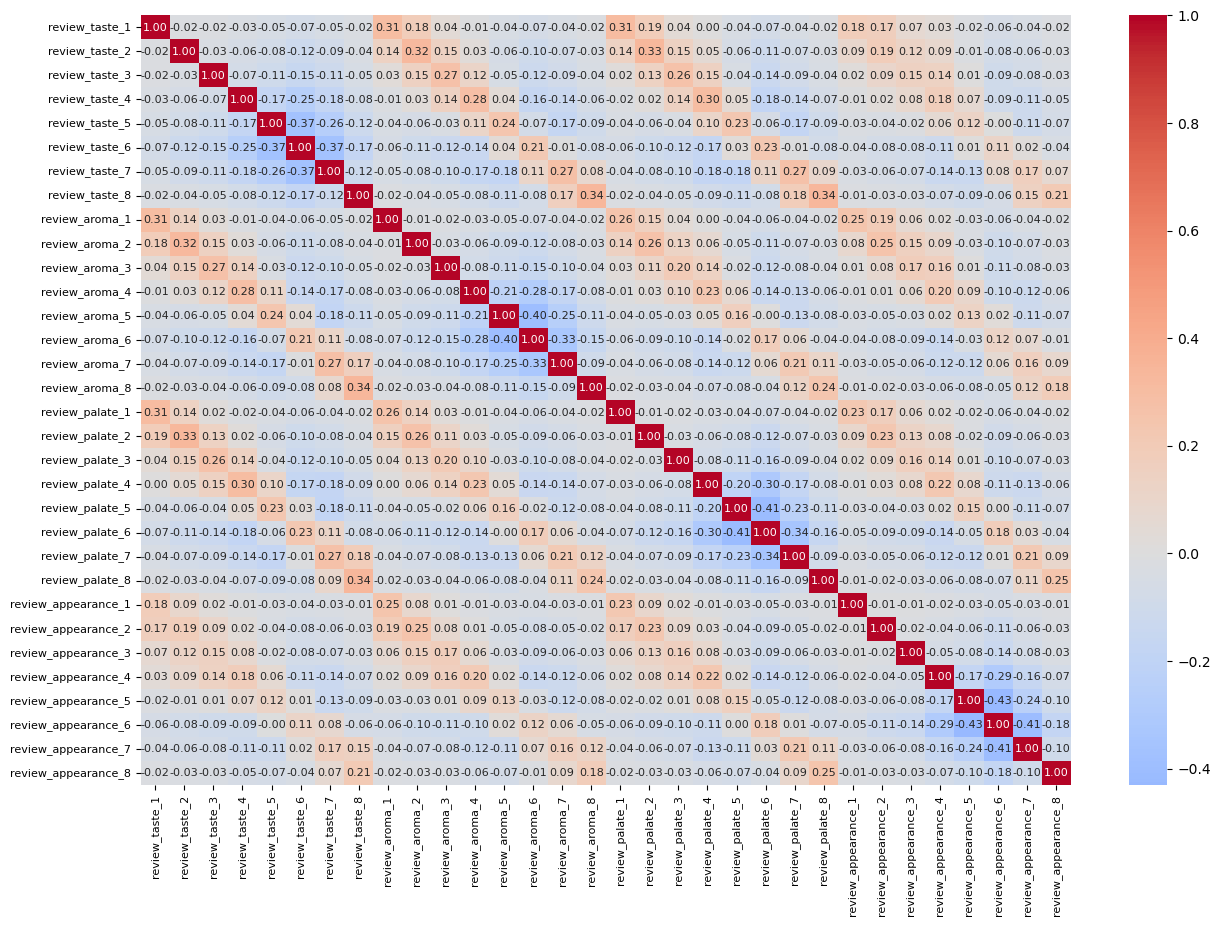

In [293]:
plt.figure(figsize=(15,10))

# Calculando a correlação
corr_matrix, p_values = spearmanr(X_dummies)

sns.heatmap(corr_matrix, annot=True,  fmt='.2f', annot_kws={"size": 8}, cmap='coolwarm', center=0,
            xticklabels=X_dummies.columns, yticklabels=X_dummies.columns)

plt.xticks(size=8) 
plt.yticks(size=8) 
plt.show()

#### 4.5.2 VIF

In [294]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data


# Aplicando a função
vif_data = calculate_vif(X_dummies)
vif_data

,feature,VIF
0,review_taste_1,2.93
1,review_taste_2,7.35
2,review_taste_3,12.08
3,review_taste_4,29.89
4,review_taste_5,58.72
5,review_taste_6,98.61
6,review_taste_7,62.42
7,review_taste_8,16.64
8,review_aroma_1,3.14
9,review_aroma_2,9.51


In [295]:
# vif_filter = vif_data.loc[vif_data['VIF'] <= 10, 'feature']

In [296]:
# X_dummies = X_dummies[vif_filter]

### 4.6 Regularization

### 4.7 Train Test Split

In [297]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

### 4.8 Undersampling

### 4.9 Oversampling

In [298]:
# smote = SMOTE()
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## 5 Model Training



### 5.1 Ordinal Logistic Regressor Model

###### Nota: NÃO requer constante

#### 5.1.1 Model

In [299]:
cross_validation_ordered_model(X_train,y_train) 

Processing fold 1/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.187787
         Iterations: 245
         Function evaluations: 246
         Gradient evaluations: 246
Processing fold 2/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.188805
         Iterations: 252
         Function evaluations: 253
         Gradient evaluations: 253
Processing fold 3/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.186982
         Iterations: 252
         Function evaluations: 253
         Gradient evaluations: 253
Processing fold 4/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.188067
         Iterations: 251
         Function evaluations: 252
         Gradient evaluations: 252
Processing fold 5/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Cur

{'accuracy': (0.513214246264064, 0.0015694676612626587),
 'recall': (0.3956067667952826, 0.002420615685932722),
 'precision': (0.48913600326718676, 0.002595658503532906),
 'f1_score': (0.4212297661964273, 0.00291864163231773),
 'mae': (0.5761649650471036, 0.0021544178923166893),
 'pseudo_r2': (0.29843657604551943, 0.00022469941728548863)}

In [300]:
ordinal_logistic_model = OrderedModel(y_train,
                        X_train,
                        distr='logit')

In [301]:
regressao_ordinal_logit = ordinal_logistic_model.fit(method='bfgs', disp=True)

Optimization terminated successfully.
         Current function value: 1.187827
         Iterations: 244
         Function evaluations: 245
         Gradient evaluations: 245


#### 5.1.2 Predict & Evaluation Metrics

In [302]:
regressao_ordinal_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         review_overall   Log-Likelihood:            -1.5055e+06
Model:                   OrderedModel   AIC:                         3.011e+06
Method:            Maximum Likelihood   BIC:                         3.012e+06
Date:                Sat, 12 Oct 2024                                         
Time:                        10:54:52                                         
No. Observations:             1267420                                         
Df Residuals:                 1267380                                         
Df Model:                          32                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
review_taste_1          1.6184      0.032     50.440      0.000       1.556       1.681
review_taste_2          3.1313      0.032     96.587      0.000       3.068       3.195
review_taste_3          4.4665      0.033    133.403      0.000       4.401       4.532
review_taste_4          5.9237      0.034    175.659      0.000       5.858       5.990
review_taste_5          7.2222      0.034    212.549      0.000       7.156       7.289
review_taste_6          8.5274      0.034    249.628      0.000       8.460       8.594
review_taste_7          9.5152      0.034    276.353      0.000       9.448       9.583
review_taste_8         10.5734      0.035    298.115      0.000      10.504      10.643
review_aroma_1          0.4209      0.037     11.277      0.000       0.348       0.494
review_aroma_2          0.5040      0.035     14.285      0.000       0.435       0.573
review_aroma_3          0.5351      0.036     14.995      0.000       0.465       0.605
review_aroma_4          0.6313      0.035     17.811      0.000       0.562       0.701
review_aroma_5          0.6791      0.036     19.120      0.000       0.609       0.749
review_aroma_6          0.8054      0.036     22.643      0.000       0.736       0.875
review_aroma_7          1.0106      0.036     28.233      0.000       0.940       1.081
review_aroma_8          1.3370      0.037     36.304      0.000       1.265       1.409
review_palate_1         0.5954      0.038     15.562      0.000       0.520       0.670
review_palate_2         0.9987      0.036     27.811      0.000       0.928       1.069
review_palate_3         1.4280      0.036     39.198      0.000       1.357       1.499
review_palate_4         1.8874      0.036     52.198      0.000       1.817       1.958
review_palate_5         2.4668      0.036     67.866      0.000       2.396       2.538
review_palate_6         3.1191      0.036     85.652      0.000       3.048       3.190
review_palate_7         3.7748      0.037    102.858      0.000       3.703       3.847
review_palate_8         4.3927      0.038    116.247      0.000       4.319       4.467
review_appearance_1     0.2343      0.054      4.365      0.000       0.129       0.339
review_appearance_2     0.0078      0.049      0.160      0.873      -0.088       0.104
review_appearance_3    -0.0884      0.049     -1.806      0.071      -0.184       0.008
review_appearance_4    -0.1355      0.048     -2.805      0.005      -0.230      -0.041
review_appearance_5    -0.1285      0.048     -2.659      0.008      -0.223      -0.034
review_appearance_6     0.0070      0.048      0.145      0.885      -0.088       0.102
review_appearance_7     0.2063      0.048      4.258      0.000       0.111       0.301
review_appearance_8     0.4894      0.049      9.963      0.000       0.393       0.586
0/1                     1.5675      0.050     31.107      0.000       1.469       

##### 5.2.1 Train Predict

In [303]:
#predict train
y_train_pred_prob = regressao_ordinal_logit.predict(X_train)

#transformando X em uma coluna para comparar
y_pred_train = np.argmax(y_train_pred_prob.values, axis=1)

#adequando a variavel resposta
y_train = y_train.values.flatten()

##### 5.2.1.1 Accuracy Train

In [304]:
#calculando a acuracia
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Acurácia Teste Logit: {accuracy_train*100} %")

Acurácia Teste Logit: 51.33018257562607 %


##### 5.2.1.2 Confusion Matrix Train

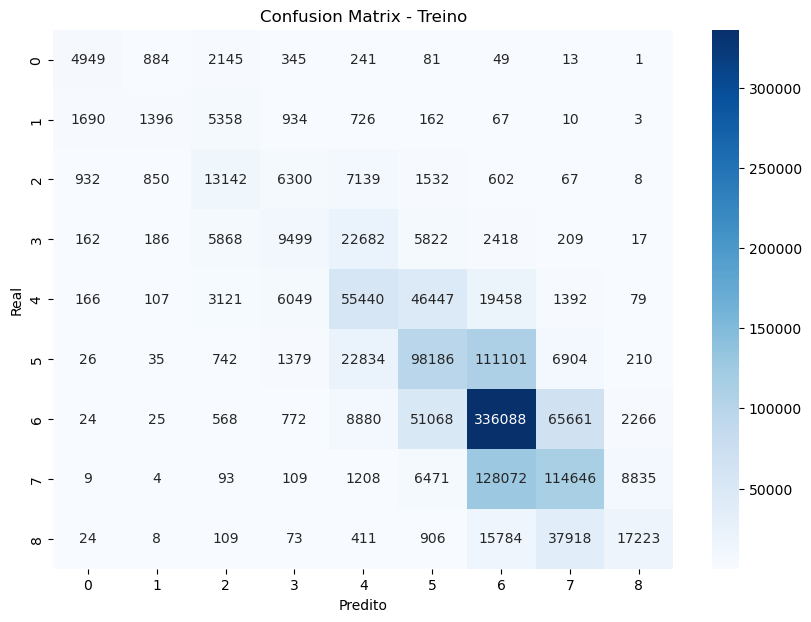

In [305]:
conf_matrix = confusion_matrix(y_train, y_pred_train, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix - Treino')
plt.show()

##### 5.2.2 Test Predict

In [306]:
#predict test
y_test_pred_prob = regressao_ordinal_logit.predict(X_test)

#transformando X em uma coluna para comparar e somando 1 pois começa no 0 os indices
y_pred_test = np.argmax(y_test_pred_prob.values, axis=1)

#adequando a variavel resposta
y_test = y_test.values.flatten()

##### 5.2.2.1 Accuracy Test

In [307]:
#calculando a acuracia
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Acurácia Teste: {accuracy_test*100} %")

Acurácia Teste: 51.32994167697629 %


##### 5.2.2.2 Confusion Matrix Test

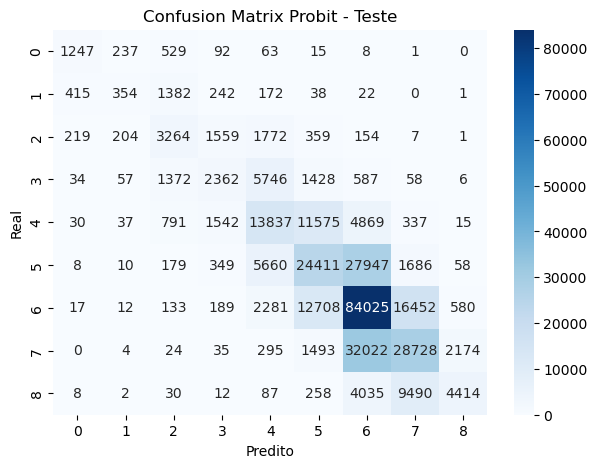

In [308]:
conf_matrix = confusion_matrix(y_test, y_pred_test, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix Probit - Teste')
plt.show()

##### 5.2.2.3 Mean Absolute Error Test

In [309]:
mae_test = mean_absolute_error(y_pred_test,y_test)

print(f"MAE: {mae_test}")

MAE: 0.5756936905092535


##### 5.2.2.4 Pseudo R²

In [310]:
r_squared_test = regressao_ordinal_logit.prsquared

print(f"Pseudo R²: {r_squared_test}")

Pseudo R²: 0.2984341522298679


##### 5.2.2.5 F1 score

In [311]:
# f1_score = f1_score(y_test, y_pred_test, average=None)

# f1_scores = [f'{score:.2f}' for score in f1_scores]
# print(f'F1 Scores de cada classe: {f1_scores}')

### 5.2 Ordinal Logistic Regressor Model - Stepwise

#### 5.2.1 Model - Stepwise

In [312]:
variaveis_remover = ['review_appearance_2', 'review_appearance_3','review_appearance_4','review_appearance_5','review_appearance_6']

In [313]:
#criando uma base que contenha todas as variáveis e os respectivos p valores
# valores_p = regressao_ordinal_logit.pvalues


# #filtrando apenas as variáveis estatísticamente significantes
# variaveis_significantes = valores_p[valores_p <= 0.05].index


# #removendo os pontos de corte que não estão presentes originalmente no X_dummies
# variaveis_significantes = variaveis_significantes[:-8]

#aplicando o filtro no X_dummies
X_dummies_stepwise = X_dummies.drop(columns=variaveis_remover)

##### 5.3.1 Stepwise VIF

In [314]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data


# Aplicando a função
vif_data = calculate_vif(X_dummies_stepwise)
vif_data

,feature,VIF
0,review_taste_1,2.86
1,review_taste_2,7.22
2,review_taste_3,11.89
3,review_taste_4,29.43
4,review_taste_5,57.85
5,review_taste_6,97.16
6,review_taste_7,61.51
7,review_taste_8,16.41
8,review_aroma_1,2.58
9,review_aroma_2,7.40


##### 5.3.2 Train Test Split Stepwise

In [315]:
# Separando os dados em treino e teste
X_train_stepwise, X_test_stepwise, y_train, y_test = train_test_split(X_dummies_stepwise, y, test_size=0.2, random_state=42)

In [316]:
cross_validation_ordered_model(X_train_stepwise,y_train)

Processing fold 1/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.188195
         Iterations: 237
         Function evaluations: 238
         Gradient evaluations: 238
Processing fold 2/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.189195
         Iterations: 236
         Function evaluations: 237
         Gradient evaluations: 237
Processing fold 3/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.187410
         Iterations: 237
         Function evaluations: 238
         Gradient evaluations: 238
Processing fold 4/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.188509
         Iterations: 225
         Function evaluations: 226
         Gradient evaluations: 226
Processing fold 5/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Cur

{'accuracy': (0.5131440248694198, 0.0015259545659095067),
 'recall': (0.39511282571425355, 0.0019150298889139166),
 'precision': (0.4883599014564776, 0.002160644931392676),
 'f1_score': (0.4208604592796162, 0.0025265292266723536),
 'mae': (0.5761097347367092, 0.0021749155893354753),
 'pseudo_r2': (0.29818740442557895, 0.00022019817665529706)}

In [317]:
ordinal_logistic_model_stepwise = OrderedModel(y_train,
                        X_train_stepwise,
                        distr='logit')

In [318]:
regressao_ordinal_logit_stepwise = ordinal_logistic_model_stepwise.fit(method='bfgs', disp=True)

Optimization terminated successfully.
         Current function value: 1.188248
         Iterations: 237
         Function evaluations: 238
         Gradient evaluations: 238


In [319]:
regressao_ordinal_logit_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         review_overall   Log-Likelihood:            -1.5060e+06
Model:                   OrderedModel   AIC:                         3.012e+06
Method:            Maximum Likelihood   BIC:                         3.013e+06
Date:                Sat, 12 Oct 2024                                         
Time:                        18:05:57                                         
No. Observations:             1267420                                         
Df Residuals:                 1267385                                         
Df Model:                          27                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
review_taste_1          1.6202      0.032     50.530      0.000       1.557       1.683
review_taste_2          3.1267      0.032     96.539      0.000       3.063       3.190
review_taste_3          4.4592      0.033    133.324      0.000       4.394       4.525
review_taste_4          5.9148      0.034    175.555      0.000       5.849       5.981
review_taste_5          7.2158      0.034    212.551      0.000       7.149       7.282
review_taste_6          8.5256      0.034    249.794      0.000       8.459       8.592
review_taste_7          9.5181      0.034    276.674      0.000       9.451       9.585
review_taste_8         10.5730      0.035    298.342      0.000      10.504      10.643
review_aroma_1          0.4129      0.037     11.218      0.000       0.341       0.485
review_aroma_2          0.4847      0.034     14.055      0.000       0.417       0.552
review_aroma_3          0.5022      0.035     14.447      0.000       0.434       0.570
review_aroma_4          0.6025      0.034     17.481      0.000       0.535       0.670
review_aroma_5          0.6640      0.035     19.241      0.000       0.596       0.732
review_aroma_6          0.8027      0.035     23.227      0.000       0.735       0.870
review_aroma_7          1.0132      0.035     29.127      0.000       0.945       1.081
review_aroma_8          1.3362      0.036     37.268      0.000       1.266       1.406
review_palate_1         0.5918      0.038     15.663      0.000       0.518       0.666
review_palate_2         0.9878      0.035     28.057      0.000       0.919       1.057
review_palate_3         1.4038      0.036     39.408      0.000       1.334       1.474
review_palate_4         1.8636      0.035     52.781      0.000       1.794       1.933
review_palate_5         2.4553      0.035     69.203      0.000       2.386       2.525
review_palate_6         3.1238      0.036     87.897      0.000       3.054       3.193
review_palate_7         3.7807      0.036    105.513      0.000       3.710       3.851
review_palate_8         4.3947      0.037    118.937      0.000       4.322       4.467
review_appearance_1     0.2946      0.031      9.600      0.000       0.234       0.355
review_appearance_7     0.2387      0.005     50.268      0.000       0.229       0.248
review_appearance_8     0.5198      0.009     54.931      0.000       0.501       0.538
0/1                     1.5986      0.039     40.822      0.000       1.522       1.675
1/2                     0.4123      0.010     43.343      0.000       0.394       0.431
2/3                     0.7240      0.006    129.046      0.000       0.713       0.735
3/4                     0.4347      0.004     97.964      0.000       0.426       0.443
4/5                     0.7651      0.003    285.363      0.000       0.760       0.770
5/6                     0.7006      0.002    362.044      0.000       0.697       

#### 5.2.2 Predict

##### Treino

In [321]:
#predict train
y_train_pred_prob_stepwise = regressao_ordinal_logit_stepwise.predict(X_train_stepwise)

#transformando X em uma coluna para comparar
y_pred_train_stepwise = np.argmax(y_train_pred_prob_stepwise.values, axis=1)

In [322]:
#calculando a acuracia
accuracy_train = accuracy_score(y_train, y_pred_train_stepwise)
print(f"Acurácia Treino Logit Stepwise: {accuracy_train*100} %")

Acurácia Treino Logit Stepwise: 51.3306559782866 %


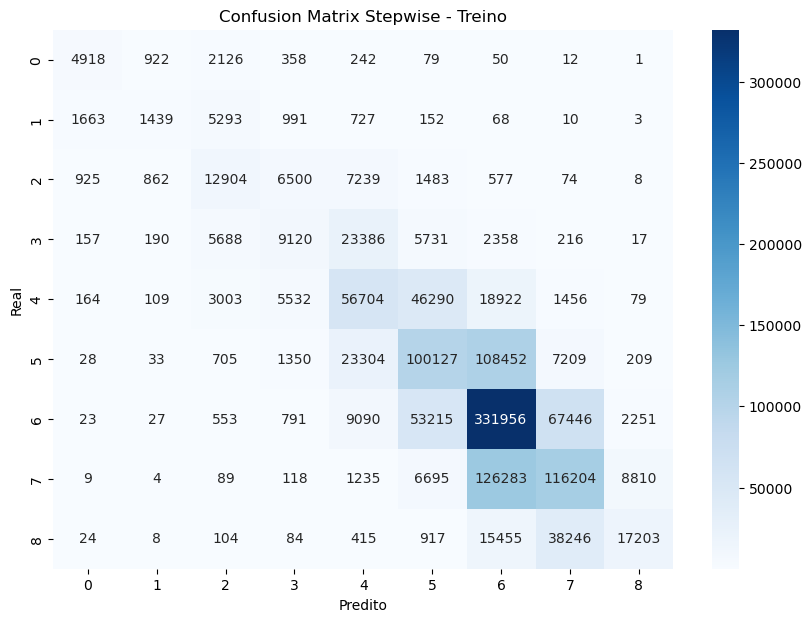

In [323]:
conf_matrix = confusion_matrix(y_train, y_pred_train_stepwise, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix Stepwise - Treino')
plt.show()

##### Teste

In [324]:
y_test_pred_prob_stepwise = regressao_ordinal_logit_stepwise.predict(X_test_stepwise)

#transformando X em uma coluna para comparar
y_pred_test_stepwise = np.argmax(y_test_pred_prob_stepwise.values, axis=1)

In [325]:
#calculando a acuracia
accuracy_test = accuracy_score(y_test, y_pred_test_stepwise)
print(f"Acurácia Teste Logit Stepwise: {accuracy_test*100} %")

Acurácia Teste Logit Stepwise: 51.34666851819123 %


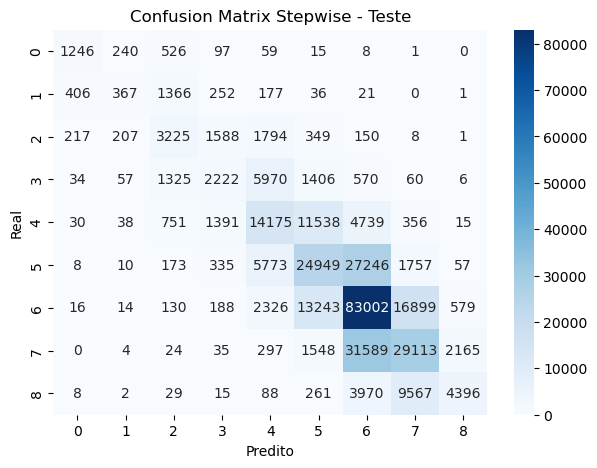

In [326]:
conf_matrix = confusion_matrix(y_test, y_pred_test_stepwise, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix Stepwise - Teste')
plt.show()


### 5.3 Ordinal Logistic Regressor Model - PCA

###### Nota: PCA pode ser feito APÓS o stepwise, mas por hora vamos com o modelo original que até agora teve melhor performance

In [371]:
remove_columns = ['review_appearance_2','review_appearance_3','review_appearance_4','review_appearance_5','review_appearance_6',]


X_dummies_stepwise = X_dummies.drop(columns=remove_columns, axis=1)

In [372]:
# Passo 1: Estandarizar os dados (muito importante para PCA)
scaler = StandardScaler()
X_dummies_scaled_stepwise = scaler.fit_transform(X_dummies_stepwise)

# Passo 2: Aplicar PCA
# Inicialize o PCA com o número de componentes desejados
# Aqui, vamos pegar componentes que expliquem 95% da variância dos dados
pca = PCA(n_components=0.95)  # Pode ajustar conforme necessário
X_dummies_stepwise_pca = pca.fit_transform(X_dummies_scaled_stepwise)
X_dummies_stepwise_pca = pd.DataFrame(X_dummies_stepwise_pca)
# X_dummies_stepwise = X_dummies_stepwise.reset_index()

# X_pca será o novo dataframe com as variáveis reduzidas
print(f"Dimensionalidade original: {X_dummies_stepwise.shape}")
print(f"Dimensionalidade após PCA: {X_dummies_stepwise_pca.shape}")

# Explicação da variância de cada componente
print("Explained variance ratio:", pca.explained_variance_ratio_)


Dimensionalidade original: (1584276, 27)
Dimensionalidade após PCA: (1584276, 21)
Explained variance ratio: [0.10522237 0.0845828  0.07249679 0.06043153 0.05346829 0.05012021
 0.04938972 0.04659226 0.04462274 0.04051665 0.0385716  0.03728141
 0.03603518 0.03435094 0.03378535 0.03154026 0.0307189  0.02912031
 0.02553005 0.02509651 0.02375599]


In [373]:
y = y.reset_index(drop=True)

###### Aqui o X_pca passa a ser meu "novo" X_dummies que será passado em treino e teste novamente para treinar o modelo

In [329]:
vif_data = calculate_vif(X_dummies_stepwise_pca)
vif_data

,feature,VIF
0,0,1.00
1,1,1.00
2,2,1.00
3,3,1.00
4,4,1.00
5,5,1.00
6,6,1.00
7,7,1.00
8,8,1.00
9,9,1.00


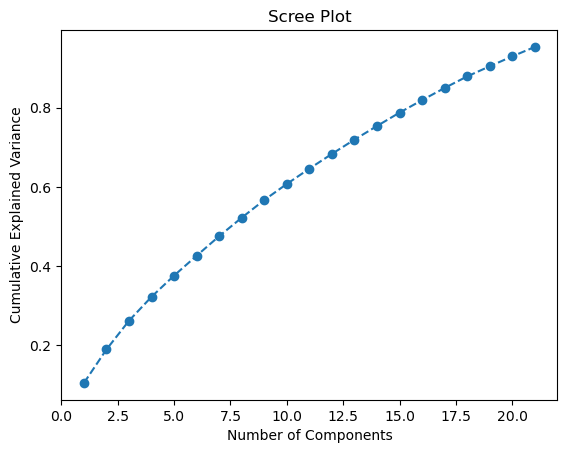

In [330]:
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(),
         marker='o',  
         linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [375]:
# Separando os dados em treino e teste
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_dummies_stepwise_pca, y, test_size=0.2, random_state=42)

In [332]:
cross_validation_ordered_model(X_train_pca,y_train) 

Processing fold 1/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.258061
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Processing fold 2/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.258995
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Processing fold 3/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.257248
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Processing fold 4/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current function value: 1.258609
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Processing fold 5/5... (vai demorá uma cota hehe)
Optimization terminated successfully.
         Current functio

{'accuracy': (0.48865727225387, 0.0012000687414073104),
 'recall': (0.28731902577664137, 0.0013920136108477464),
 'precision': (0.35775018457902086, 0.0016600685988764105),
 'f1_score': (0.30230626561343044, 0.0013351279243962704),
 'mae': (0.6399662306102161, 0.00234147803907895),
 'pseudo_r2': (0.2569289331701058, 0.00020843349317382337)}

In [376]:
ordinal_logistic_model_pca = OrderedModel(y_train,
                        X_train_pca,
                        distr='logit')

In [377]:
regressao_ordinal_logit_pca = ordinal_logistic_model_pca.fit(method='bfgs', disp=True)

Optimization terminated successfully.
         Current function value: 1.258103
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51


In [378]:
regressao_ordinal_logit_pca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         review_overall   Log-Likelihood:            -1.5945e+06
Model:                   OrderedModel   AIC:                         3.189e+06
Method:            Maximum Likelihood   BIC:                         3.189e+06
Date:                Sun, 13 Oct 2024                                         
Time:                        11:01:34                                         
No. Observations:             1267420                                         
Df Residuals:                 1267391                                         
Df Model:                          21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.3190      0.002   -874.123      0.000      -1.322      -1.316
1             -0.0666      0.001    -49.132      0.000      -0.069      -0.064
2             -0.2965      0.001   -220.726      0.000      -0.299      -0.294
3              0.1347      0.001     98.971      0.000       0.132       0.137
4             -0.0064      0.001     -4.489      0.000      -0.009      -0.004
5              0.0216      0.001     14.987      0.000       0.019       0.024
6              0.0404      0.001     27.994      0.000       0.038       0.043
7              0.0297      0.001     19.912      0.000       0.027       0.033
8             -0.0060      0.001     -4.019      0.000      -0.009      -0.003
9              0.0183      0.002     11.489      0.000       0.015       0.021
10             0.0613      0.002     37.011      0.000       0.058       0.065
11            -0.0035      0.002     -2.115      0.034      -0.007      -0.000
12             0.0503      0.002     29.789      0.000       0.047       0.054
13             0.0667      0.002     37.418      0.000       0.063       0.070
14             0.0180      0.002     10.127      0.000       0.015       0.022
15             0.1112      0.002     57.526      0.000       0.107       0.115
16             0.0565      0.002     29.921      0.000       0.053       0.060
17             0.0891      0.002     43.664      0.000       0.085       0.093
18            -0.0354      0.002    -16.963      0.000      -0.039      -0.031
19            -0.0320      0.002    -15.175      0.000      -0.036      -0.028
20            -0.3044      0.002   -140.470      0.000      -0.309      -0.300
0/1           -8.1037      0.014   -573.425      0.000      -8.131      -8.076
1/2           -0.0374      0.010     -3.840      0.000      -0.056      -0.018
2/3            0.4022      0.006     72.003      0.000       0.391       0.413
3/4            0.2136      0.004     48.062      0.000       0.205       0.222
4/5            0.6154      0.003    233.177      0.000       0.610       0.621
5/6            0.6117      0.002    319.029      0.000       0.608       0.615
6/7            0.9552      0.001    700.761      0.000       0.953       0.958
7/8            0.8779      0.002    457.281      0.000       0.874       0.882
==============================================================================
"""

In [379]:
#predict train
y_train_pred_prob_pca = regressao_ordinal_logit_pca.predict(X_train_pca)

#transformando X em uma coluna para comparar
y_pred_train_pca = np.argmax(y_train_pred_prob_pca.values, axis=1)

#adequando a variavel resposta
# y_train = y_train.values.flatten()

In [380]:
#calculando a acuracia
accuracy_train_pca = accuracy_score(y_train, y_pred_train_pca)
print(f"Acurácia Treino: {accuracy_train_pca*100} %")

Acurácia Treino: 48.86517492228306 %


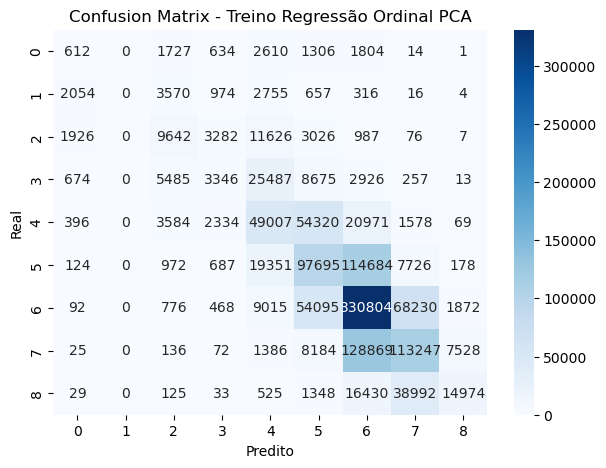

In [381]:
conf_matrix = confusion_matrix(y_train, y_pred_train_pca, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix - Treino Regressão Ordinal PCA')
plt.show()

In [382]:
#predict test
y_test_pred_prob_pca = regressao_ordinal_logit_pca.predict(X_test_pca)

#transformando X em uma coluna para comparar
y_pred_test_pca = np.argmax(y_test_pred_prob_pca.values, axis=1)

#adequando a variavel resposta
# y_test = y_test.values.flatten()

In [383]:
#calculando a acuracia
accuracy_test_pca = accuracy_score(y_test, y_pred_test_pca)
print(f"Acurácia Teste: {accuracy_test_pca*100} %")

Acurácia Teste: 48.82628070795567 %


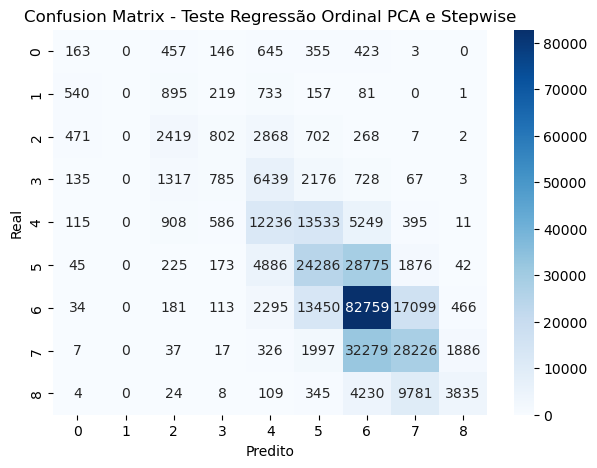

In [384]:
conf_matrix = confusion_matrix(y_test, y_pred_test_pca, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix - Teste Regressão Ordinal PCA e Stepwise')
plt.show()

In [385]:
mae_test = mean_absolute_error(y_pred_test_pca,y_test)

print(f"MAE PCA: {mae_test}")

MAE PCA: 0.6396438760825107


In [386]:
r_squared_test = regressao_ordinal_logit_pca.prsquared

print(f"Pseudo R² PCA: {r_squared_test}")

Pseudo R² PCA: 0.2569271983617595


In [387]:
f1_score = f1_score(y_test, y_pred_test_pca, average=None)

f1_scores = [f'{score:.2f}' for score in f1_score]
print(f'F1 Scores de cada classe: {f1_scores}')

F1 Scores de cada classe: ['0.09', '0.00', '0.35', '0.11', '0.38', '0.41', '0.61', '0.46', '0.31']


### 5.4 Multinomial Logistic Regressor

In [2]:
#adicionando a constante
X_train_pca_const = sm.add_constant(X_train_pca)

#instanciando o modelo
model = sm.MNLogit(y_train, X_train_pca_const)

NameError: name 'sm' is not defined

In [389]:
result = model.fit(
    method='bfgs', 
    maxiter=1000,
    disp=True         
)

MemoryError: Unable to allocate 87.0 MiB for an array with shape (1267420, 9) and data type float64

In [290]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:         review_overall   No. Observations:              1269291
Model:                        MNLogit   Df Residuals:                  1269067
Method:                           MLE   Df Model:                          216
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                  0.2957
Time:                        14:28:59   Log-Likelihood:            -1.5141e+06
converged:                       True   LL-Null:                   -2.1498e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
review_overall=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.8686      0.032    -27.069      0.000      -0.931      -0.806
0                    0.2219      0.014     16.241      0.000       0.195       0.249
1                    0.0497      0.018      2.816      0.005       0.015       0.084
2                    0.0497      0.018      2.833      0.005       0.015       0.084
3                   -0.0247      0.017     -1.414      0.157      -0.059       0.010
4                   -0.0142      0.025     -0.569      0.569      -0.063       0.035
5                   -0.0448      0.024     -1.903      0.057      -0.091       0.001
6                   -0.0436      0.017     -2.591      0.010      -0.077      -0.011
7                   -0.0030      0.025     -0.119      0.906      -0.053       0.047
8                   -0.0088      0.025     -0.353      0.724      -0.058       0.040
9                    0.0499      0.015      3.333      0.001       0.021       0.079
10                  -0.0008      0.022     -0.037      0.971      -0.043       0.041
11                  -0.0288      0.022     -1.296      0.195      -0.072       0.015
12                   0.0656      0.018      3.562      0.000       0.029       0.102
13                   0.0053      0.020      0.272      0.786      -0.033       0.044
14                  -0.0259      0.014     -1.853      0.064      -0.053       0.001
15                  -0.0188      0.017     -1.078      0.281      -0.053       0.015
16                  -0.0581      0.016     -3.643      0.000      -0.089      -0.027
17                  -0.0506      0.017     -3.019      0.003      -0.083      -0.018
18                   0.0931      0.019      4.881      0.000       0.056       0.131
19                   0.0829      0.021      4.012      0.000       0.042       0.123
20                   0.0526      0.020      2.589      0.010       0.013       0.092
21                   0.0255      0.022      1.162      0.245      -0.017       0.068
22                  -0.0591      0.023     -2.590      0.010      -0.104      -0.014
23                  -0.0584      0.024     -2.432      0.015      -0.105      -0.011
24                  -0.5495      0.020    -27.602      0.000      -0.588      -0.510
25                   0.1831      0.019      9.467      0.000       0.145       0.221
26                  -0.1695      0.021     -7.888      0.000      -0.212      -0.127
------------------------------------------------------------------------------------
review_overall=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1351      0.029     -4.677      0.000      -0.192      -0.079
0                    0.5387      0.013     42.714      0.000       0.514       0.563
1                   -0.1856      0.019     -9.870      0.000      -0.222      -0.149
2                    0.0846      0.019      4.512      0.000       0.048       0.121
3          

In [291]:
#predict train
y_train_pred_prob_pca_multi = result.predict(X_train_pca_const)

#transformando X em uma coluna para comparar
y_pred_train_pca_multi = np.argmax(y_train_pred_prob_pca_multi.values, axis=1)

In [292]:
#calculando a acuracia
accuracy_train_pca = accuracy_score(y_train, y_pred_train_pca_multi)
print(f"Acurácia Treino: {accuracy_train_pca*100} %")

Acurácia Treino: 51.08056387384769 %


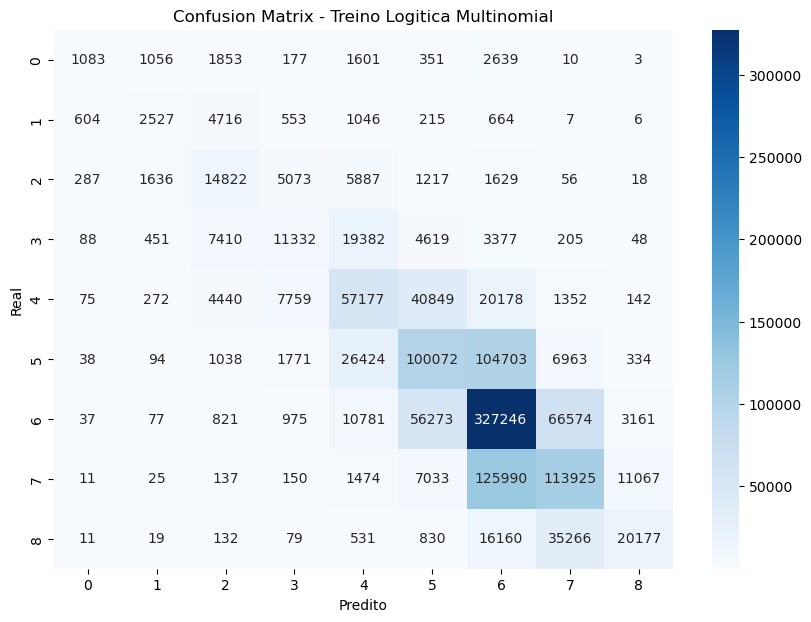

In [312]:
conf_matrix = confusion_matrix(y_train, y_pred_train_pca_multi, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix - Treino Logitica Multinomial')
plt.show()

In [294]:
X_test_pca_const = sm.add_constant(X_test_pca)

#predict test
y_test_pred_prob_pca_multi = result.predict(X_test_pca_const)

#transformando X em uma coluna para comparar
y_pred_test_pca_multi = np.argmax(y_test_pred_prob_pca_multi.values, axis=1)

In [295]:
#calculando a acuracia
accuracy_test_pca = accuracy_score(y_test, y_pred_test_pca_multi)
print(f"Acurácia Teste: {accuracy_test_pca*100} %")

Acurácia Teste: 51.10849197820517 %


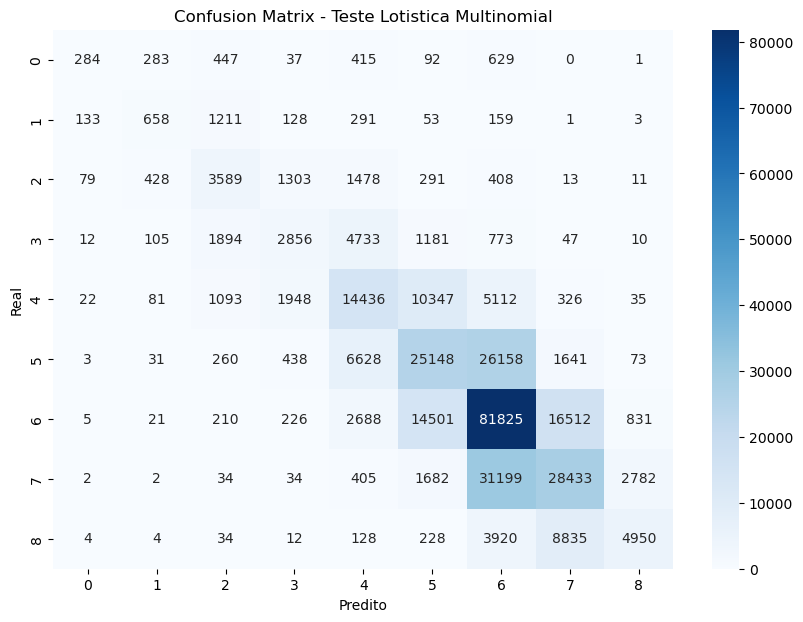

In [313]:
conf_matrix = confusion_matrix(y_test, y_pred_test_pca_multi, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix - Teste Lotistica Multinomial')
plt.show()

In [297]:
chi2(result)

,Qui_quadrado,p_value
0,1271510.48,0.00


## XGBoost

In [308]:
y = y.astype('int')

# 4. Dividir os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

# 5. Instanciar e treinar o modelo XGBClassifier
xgb_model = XGBClassifier(eval_metric='mlogloss', 
                          objective='multi:softprob',
                          n_estimators=100,
                          learning_rate=0.1,
                          max_depth=8,
                          min_child_weight=3,
                          subsample=1.0,
                          colsample_bytree=0.5) 
xgb_model.fit(X_train, y_train)



KeyboardInterrupt: 

In [299]:
# 6. Fazer previsões no conjunto de teste
y_pred_train = xgb_model.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63      8773
           1       0.44      0.30      0.36     10338
           2       0.43      0.51      0.47     30625
           3       0.42      0.26      0.32     46912
           4       0.47      0.49      0.48    132244
           5       0.48      0.40      0.44    241437
           6       0.55      0.71      0.62    465945
           7       0.51      0.43      0.47    259812
           8       0.59      0.27      0.37     73205

    accuracy                           0.52   1269291
   macro avg       0.50      0.44      0.46   1269291
weighted avg       0.52      0.52      0.51   1269291



In [300]:
accuracy_score(y_train, y_pred_train)

0.5196877626958673

In [301]:
# 6. Fazer previsões no conjunto de teste
y_pred_test = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60      2188
           1       0.38      0.26      0.31      2637
           2       0.41      0.48      0.44      7600
           3       0.40      0.25      0.31     11611
           4       0.47      0.48      0.47     33400
           5       0.48      0.40      0.44     60380
           6       0.55      0.70      0.62    116819
           7       0.51      0.43      0.47     64573
           8       0.58      0.26      0.36     18115

    accuracy                           0.52    317323
   macro avg       0.49      0.43      0.45    317323
weighted avg       0.51      0.52      0.51    317323



In [302]:
accuracy_score(y_test, y_pred_test)

0.5167983411224525

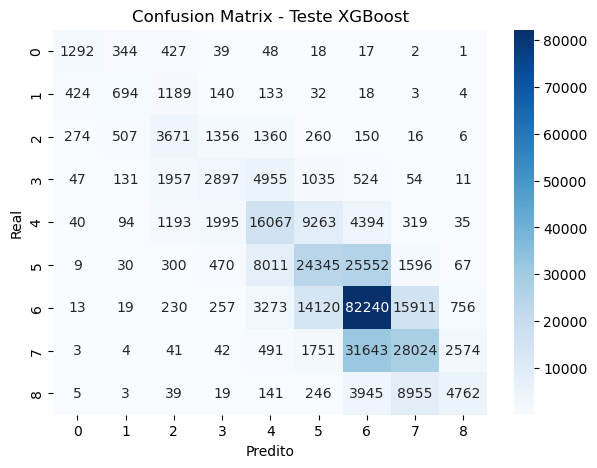

In [307]:
conf_matrix = confusion_matrix(y_test, y_pred_test, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix - Teste XGBoost')
plt.show()

## Random Forest

In [304]:

y = y.astype('category').values
# 3. Dividir os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

# 4. Instanciar o modelo RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100,  # Número de árvores na floresta
                                  max_depth=10,      # Profundidade máxima das árvores
                                  random_state=42,   # Para reprodução dos resultados
                                  class_weight='balanced')  # Lidar com possíveis desbalanceamentos nas classes

# 5. Ajustar o modelo ao conjunto de treino
rf_model.fit(X_train, y_train)

# 6. Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# 7. Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

# Imprimir relatório de classificação detalhado
print(classification_report(y_test, y_pred))

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_12064\3837170109.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Acurácia: 0.46
              precision    recall  f1-score   support

           0       0.30      0.61      0.40      2188
           1       0.31      0.52      0.39      2637
           2       0.39      0.43      0.41      7600
           3       0.31      0.47      0.37     11611
           4       0.41      0.46      0.44     33400
           5       0.44      0.48      0.46     60380
           6       0.61      0.41      0.49    116819
           7       0.44      0.48      0.46     64573
           8       0.35      0.56      0.43     18115

    accuracy                           0.46    317323
   macro avg       0.40      0.49      0.43    317323
weighted avg       0.49      0.46      0.46    317323



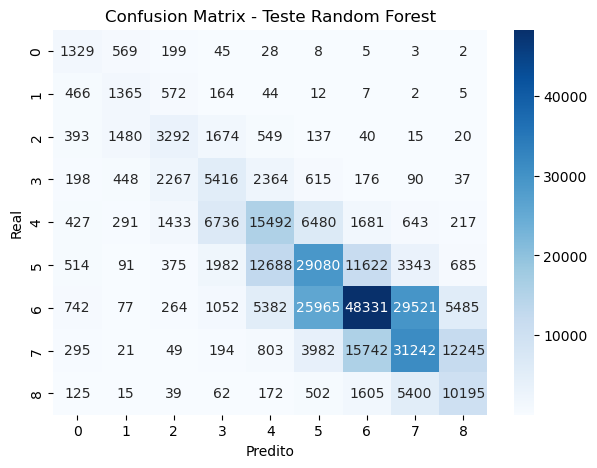

In [311]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=range(0, 9))

# Plotar a matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(0, 9), yticklabels=range(0, 9))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Confusion Matrix - Teste Random Forest')
plt.show()

### 5.2 Ordinal Logistic Regressor Model - Oversampled

In [306]:
mod_log_over = OrderedModel(y_resampled,
                        X_resampled,
                        distr='logit')

NameError: name 'y_resampled' is not defined

In [219]:
res_log_over = mod_log_over.fit(method='bfgs', disp=True)
res_log_over.summary()

         Current function value: 2.032357
         Iterations: 63
         Function evaluations: 140
         Gradient evaluations: 132


c:\Users\Alexandre\anaconda3\lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\Alexandre\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         review_overall   Log-Likelihood:            -8.5227e+06
Model:                   OrderedModel   AIC:                         1.705e+07
Method:            Maximum Likelihood   BIC:                         1.705e+07
Date:                Tue, 08 Oct 2024                                         
Time:                        04:55:21                                         
No. Observations:             4193505                                         
Df Residuals:                 4193465                                         
Df Model:                          32                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
review_aroma_2.0         -0.0112        nan        nan        nan         nan         nan
review_aroma_3.0         -0.0151        nan        nan        nan         nan         nan
review_aroma_4.0         -0.0187        nan        nan        nan         nan         nan
review_aroma_5.0         -0.0148        nan        nan        nan         nan         nan
review_aroma_6.0         -0.0161        nan        nan        nan         nan         nan
review_aroma_7.0         -0.0119        nan        nan        nan         nan         nan
review_aroma_8.0         -0.0093        nan        nan        nan         nan         nan
review_aroma_9.0         -0.0075        nan        nan        nan         nan         nan
review_appearance_2.0    -0.0115        nan        nan        nan         nan         nan
review_appearance_3.0    -0.0107        nan        nan        nan         nan         nan
review_appearance_4.0    -0.0135        nan        nan        nan         nan         nan
review_appearance_5.0    -0.0121        nan        nan        nan         nan         nan
review_appearance_6.0    -0.0192        nan        nan        nan         nan         nan
review_appearance_7.0    -0.0130        nan        nan        nan         nan         nan
review_appearance_8.0    -0.0092        nan        nan        nan         nan         nan
review_appearance_9.0    -0.0114        nan        nan        nan         nan         nan
review_palate_2.0        -0.0134        nan        nan        nan         nan         nan
review_palate_3.0        -0.0155        nan        nan        nan         nan         nan
review_palate_4.0        -1.4138        nan        nan        nan         nan         nan
review_palate_5.0        -0.0195        nan        nan        nan         nan         nan
review_palate_6.0        -0.0230        nan        nan        nan         nan         nan
review_palate_7.0        -0.0150        nan        nan        nan         nan         nan
review_palate_8.0        -0.0104        nan        nan        nan         nan         nan
review_palate_9.0        -0.0048        nan        nan        nan         nan         nan
review_taste_2.0         -0.0182        nan        nan        nan         nan         nan
review_taste_3.0         -0.0344        nan        nan        nan         nan         nan
review_taste_4.0         -1.1125        nan        nan        nan         nan         nan
review_taste_5.0         -0.0212        nan        nan        nan         nan         nan
review_taste_6.0         -0.0139        nan        nan        nan         nan         nan
review_taste_7.0         -0.0090        nan        nan        nan         nan         nan
review_taste_8.0          0.0021        nan        nan        nan         nan         nan
review_taste_9.0          2.3766        nan        nan        nan         nan         nan
2/3         

In [220]:
#predict train
y_train_pred_prob_over = res_log_over.predict(X_train)

#transformando X em uma coluna para comparar e somando 1 pois começa no 0 os indices
y_pred_train_over = np.argmax(y_train_pred_prob_over.values, axis=1) + 2

#adequando a variavel resposta
y_train_over = y_resampled.values.flatten()

In [221]:
#predict test
y_test_pred_prob_over = res_log_over.predict(X_test)

#transformando X em uma coluna para comparar e somando 1 pois começa no 0 os indices
y_pred_test_over = np.argmax(y_test_pred_prob_over.values, axis=1) + 2

#adequando a variavel resposta
y_test = y_test.values.flatten()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

## 9 DELETAR

### REGRESSÃO LOGISTICA MULTINOMIAL - REQUER CONSTANTE

### 4.4 Train/Test split

In [144]:
X_train_Scaled, X_test_Scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(X_train_Scaled.shape, X_test_Scaled.shape, y_train.shape, y_test.shape)

(1269279, 4) (317320, 4) (1269279,) (317320,)


### 4.5 Preparing X for Training

In [145]:
X_train_Scaled_Data_Frame = pd.DataFrame(X_train_Scaled)
X_test_Scaled_Data_Frame = pd.DataFrame(X_test_Scaled)

###### Nota: Decidimos não utilizar a métrica MAPE pois a distribuição dos dados na variável resposta é desbalanceada e os números são muito pequenos, o que, após o cross validation ser executado, resulta em um disparo do indicador. Elencando soluções, poderíamos efetuar o cross validation estratificado, ou multiplicar os valores da variável resposta por algum fator, mas não se justifica por termos outras métricas mais relevantes que serão adotadas a seguir: 

##### MAE - Mean Absolute Error

##### MSE - Mean Squared Error

##### RMSE - Root Mean Squared Error

### 5.1 Linear Regressor

In [146]:
#modelo
linear_regressor = LinearRegression().fit(X_train_Scaled, y_train)

#predição
linear_regressor_pred = linear_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
linear_regressor_pred_rounded = np.round(linear_regressor_pred / 0.5) * 0.5

#avaliando
linear_regressor_result = ml_error('Linear Regressor', y_test, linear_regressor_pred_rounded)

#exibindo o resultado
linear_regressor_result

,Model Name,MAE,MSE,RMSE,R²
0,Linear Regressor,0.29,0.20,0.45,0.62


In [147]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': linear_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 50.03%


#### 5.1.1 Linear Regressor Cross Validation

In [148]:
linear_regressor_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, linear_regressor, kfold=5)

linear_regressor_cv['model'] = "Linear Regression"

### 5.2 Decision Tree Regressor

In [149]:
#definindo parâmetros
decision_tree_regressor = DecisionTreeRegressor(
    max_depth=8,             
    min_samples_split=5,     
    min_samples_leaf=5,       
    random_state=42
)

#modelo
decision_tree_regressor.fit(X_train_Scaled, y_train)

#predição
decision_tree_regressor_pred = decision_tree_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
decision_tree_regressor_pred_rounded = np.round(decision_tree_regressor_pred / 0.5) * 0.5

#avaliando
decision_tree_result = ml_error('Decision Tree Regression', y_test, decision_tree_regressor_pred_rounded)

#exibindo o resultado
decision_tree_result


,Model Name,MAE,MSE,RMSE,R²
0,Decision Tree Regression,0.29,0.19,0.44,0.63


In [150]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': decision_tree_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.03%


#### 5.2.1 Decision Tree Cross Validation

In [151]:
decision_tree_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, decision_tree_regressor, kfold=5)

decision_tree_cv['model'] = "Decision Tree"

### 5.2 XGBoost Regressor

In [152]:
#definindo parâmetros
xgb_regressor = XGBRegressor(
    max_depth=10,               # Profundidade máxima da árvore
    n_estimators=100,          # Número de árvores no ensemble
    learning_rate=0.2,         # Taxa de aprendizado
    subsample=0.8,             # Proporção de amostras usadas para treinar cada árvore
    colsample_bytree=0.8,      # Proporção de features usadas para cada árvore
    random_state=22
)

#modelo
xgb_regressor.fit(X_train_Scaled, y_train)

#predição
xgb_regressor_pred = xgb_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
xgb_regressor_pred_rounded = np.round(xgb_regressor_pred / 0.5) * 0.5

#avaliando
xgb_regressor_result = ml_error('XGBoost Regression', y_test, xgb_regressor_pred_rounded)

#exibindo o resultado
xgb_regressor_result

,Model Name,MAE,MSE,RMSE,R²
0,XGBoost Regression,0.29,0.19,0.44,0.63


#### 5.2.a XGBoost Feature Importance

In [153]:
xgb_regressor.feature_importances_

array([0.00379279, 0.90532243, 0.08471246, 0.00617236], dtype=float32)

In [154]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': xgb_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.10%


#### 5.2.2 XGBoost Cross Validation

In [155]:
xgb_regressor_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, xgb_regressor, kfold=5)

xgb_regressor_cv['model'] = "XGBoost Regressor"

### 5.3 Random Forest Regressor

In [156]:
#definindo parâmetros
rf_regressor = RandomForestRegressor(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=10,              # Profundidade máxima das árvores
    min_samples_split=10,      # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5,        # Número mínimo de amostras por folha
    random_state=42
)

#modelo
rf_regressor.fit(X_train_Scaled, y_train)

#predição
rf_regressor_pred = rf_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
rf_regressor_pred_rounded = np.round(rf_regressor_pred / 0.5) * 0.5

#avaliando
rf_regressor_result = ml_error('Random Forest Regression', y_test, rf_regressor_pred_rounded)

#exibindo o resultado
rf_regressor_result

,Model Name,MAE,MSE,RMSE,R²
0,Random Forest Regression,0.29,0.19,0.44,0.63


In [157]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': rf_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.11%


In [158]:
rf_regressor.feature_importances_

array([0.00396932, 0.93863848, 0.05262562, 0.00476658])

#### 5.3.1 Random Forest Cross Validation

In [159]:
rf_regressor_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, rf_regressor, kfold=5)

rf_regressor_cv['model'] = "Random Forest"

### 5.4 Results

#### 5.4.1 Initial Models

In [160]:
model_results = pd.concat([linear_regressor_result, decision_tree_result, rf_regressor_result, xgb_regressor_result], axis=0)
print(model_results)

                 Model Name  MAE  MSE  RMSE   R²
0          Linear Regressor 0.29 0.20  0.45 0.62
0  Decision Tree Regression 0.29 0.19  0.44 0.63
0  Random Forest Regression 0.29 0.19  0.44 0.63
0        XGBoost Regression 0.29 0.19  0.44 0.63


#### 5.4.2 Cross Validation Models

In [161]:
cv_model_results = pd.concat([linear_regressor_cv, decision_tree_cv, rf_regressor_cv, xgb_regressor_cv], axis=0)
print(cv_model_results)

      MAE  MSE  RMSE   R²              model
Mean 0.31 0.18  0.42 0.66  Linear Regression
Std  0.00 0.00  0.00 0.00  Linear Regression
Mean 0.31 0.17  0.42 0.67      Decision Tree
Std  0.00 0.00  0.00 0.00      Decision Tree
Mean 0.31 0.17  0.42 0.67      Random Forest
Std  0.00 0.00  0.00 0.00      Random Forest
Mean 0.31 0.17  0.42 0.66  XGBoost Regressor
Std  0.00 0.00  0.00 0.00  XGBoost Regressor


### 6.1 XGBoost Fine Tunning

In [162]:
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Número de árvores
#     'max_depth': [3, 5, 7, 9],        # Profundidade máxima da árvore
#     'min_child_weight': [1, 3, 5],    # Importante para evitar overfitting
#     'learning_rate': [0.01, 0.1, 0.2], # Taxa de aprendizado
# }

# xgb_regressor = XGBRegressor()


# grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, 
#                            scoring='neg_mean_absolute_error', 
#                            cv=5, n_jobs=-1, verbose=1)

# grid_search.fit(X_train_Scaled, y_train)

# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("Melhor MAE:", -grid_search.best_score_)
